In [59]:
# import HOG
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
import faiss
import pandas as pd


In [60]:
import warnings
warnings.simplefilter("ignore")

In [61]:
paths_db = pd.read_csv("database/db.csv", index_col=0)
paths = paths_db['image'].values.tolist()
paths = ["images\\" + path for path in paths]

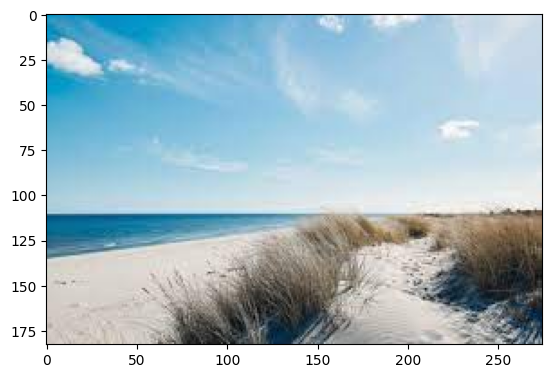

In [62]:
image = cv2.imread(paths[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [63]:
def preprocess_image(path):
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (224, 224))
    return image

In [64]:
def extract_hog_features(path):
    image = preprocess_image(path)
    features, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True, block_norm='L2-Hys')
    return features, hog_image

In [65]:
hog_features = []
for path in paths:
    features, hog_image = extract_hog_features(path)
    hog_features.append(features)

hog_features = np.array(hog_features)

In [66]:
hog_features[0].shape

(26244,)

In [86]:
query_image_path = "images\Training Data\Desert\Desert-Train (1001).jpeg"

In [87]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_images(query_image_path, image_features, image_paths,  top_k=5):
    # Extraer características de la imagen de consulta
    query_features, _ = extract_hog_features(query_image_path)

    # Calcular similitud coseno entre la consulta y todas las imágenes
    similarities = cosine_similarity([query_features], image_features)[0]

    similar_indices = np.argsort(similarities)[::-1][:top_k]

    similar_images = [image_paths[i] for i in similar_indices]
    return similar_images

In [88]:
hog_features.shape

(500, 26244)

In [89]:
similar_images = find_similar_images(query_image_path, hog_features, paths)

print("Imágenes más similares:")
for img_path in similar_images:
    print(img_path)

Imágenes más similares:
images\Training Data\Desert\Desert-Train (1001).jpeg
images\Training Data\Forest\Forest-Train (1025).jpeg
images\Training Data\Forest\Forest-Train (1002).jpeg
images\Training Data\Desert\Desert-Train (1060).jpeg
images\Training Data\Forest\Forest-Train (1062).jpeg


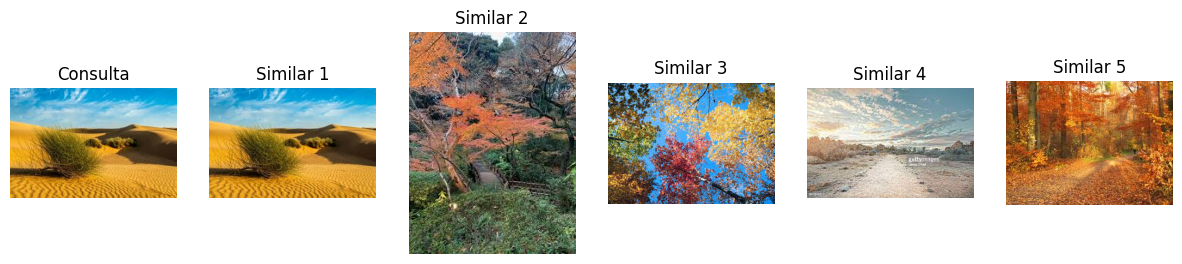

In [90]:
import matplotlib.pyplot as plt

def show_similar_images(query_image, similar_images):
    # Mostrar imagen de consulta
    plt.figure(figsize=(15, 5))
    plt.subplot(1, len(similar_images) + 1, 1)
    plt.imshow(cv2.cvtColor(cv2.imread(query_image), cv2.COLOR_BGR2RGB))
    plt.title("Consulta")
    plt.axis("off")

    # Mostrar imágenes similares
    for i, img_path in enumerate(similar_images, 2):
        plt.subplot(1, len(similar_images) + 1, i)
        plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
        plt.title(f"Similar {i-1}")
        plt.axis("off")

    plt.show()

# Visualiza las imágenes
show_similar_images(query_image_path, similar_images)


In [91]:
import faiss

# Indexar las características
dimension = hog_features.shape[1]
index = faiss.IndexFlatL2(dimension)  # Índice para búsqueda por distancia L2
index.add(hog_features)

faiss.write_index(index, 'database\hog.index')

In [95]:
query_image_path = paths[33]
query_features, _ = extract_hog_features(query_image_path)
distances, indices = index.search(query_features[np.newaxis, :], k=5)

print("Indices of nearest neighbors:", indices)
print("Distances to nearest neighbors:", distances)

Indices of nearest neighbors: [[ 33 323  85  39 195]]
Distances to nearest neighbors: [[  0.      406.9656  420.1137  423.12244 425.11978]]


In [96]:
import matplotlib.pyplot as plt

def show_faiss_results(query_image_path, similar_indices, image_paths):
    # Número de resultados a mostrar
    num_results = len(similar_indices)

    # Configurar la figura
    plt.figure(figsize=(15, 5))

    # Mostrar la imagen de consulta
    plt.subplot(1, num_results + 1, 1)
    plt.imshow(cv2.cvtColor(cv2.imread(query_image_path), cv2.COLOR_BGR2RGB))
    plt.title("Consulta")
    plt.axis("off")

    # Mostrar las imágenes similares

    for i, idx in enumerate(similar_indices, start=2):
        plt.subplot(1, num_results + 1, i)
        similar_image_path = image_paths[idx]
        plt.imshow(cv2.cvtColor(cv2.imread(similar_image_path), cv2.COLOR_BGR2RGB))
        plt.title(f"Similar {i-1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

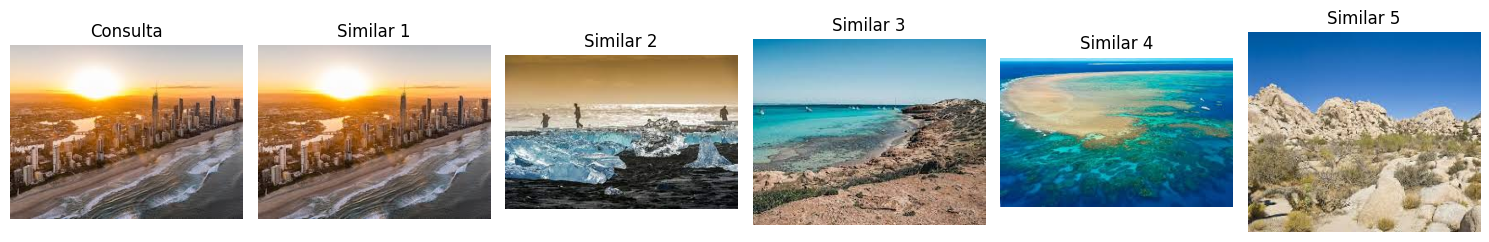

In [97]:
show_faiss_results( query_image_path, indices[0], paths)